# Исследование объявлений о продаже квартир
**Цель проекта:**  

Нужно научиться определять рыночную стоимость объектов недвижимости для построения автоматизированной системы. Задача — установить параметры, что позволит отследить аномалии и мошенническую деятельность. 

**Имеющиеся данные**  

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.  

**Ход исследования**  
- предобработка данных
- исследовательский анализ данных 
- анализ ключевых показателей:
    - времени продажи квартиры
    - зависимость цены от площади, числа комнат и высоты потолков
    - определение наиболее представленных населенных пунктов
    - углубленный анализ по сегменту центр г.Санкт-Петербург

## Изучение данных из файла

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
local_path = './real_estate_data.csv'
server_path = '/datasets/real_estate_data.csv'

try:
    data = pd.read_csv(local_path, sep='\t')
except:
    data = pd.read_csv(server_path, sep='\t')

In [3]:
# data = pd.read_csv('/datasets/real_estate_data.csv', )

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [5]:
display(data.head(5))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [6]:
for col in data.columns:
    if data[col].dtype == 'int64' or data[col].dtype == 'float64':
        if ((data[col] < 0).any()) == True:
            print(col)

### Вывод

Всего в таблице 22 столбцов и 23699 строк. Пропуски значений (NaN) есть в 12 столбцах.  
    
Названия столбцов корректны:  
- в них отсутствуют лишние пробелы и кирилические символы  
- в качестве разделителя слов использовано подчеркивание (_).  

Тип данных в колонке "is_apartment" - object (строковый), значения которые в нем хранятся подразумевают булевый тип данных (bool).  
В столбцах 'last_price', 'floors_total', 'balcony' и 'days_exposition' значения представлены типом float64, по смыслу подразумевается int64.  
Отрицательных значений в числовых столбцах (float64 и int64) нет.


## Предобработка данных

### Обработка пропусков

In [7]:
for col in data.columns:
    print(col, len(data[col].unique()))

total_images 38
last_price 2978
total_area 2182
first_day_exposition 1491
rooms 17
ceiling_height 184
floors_total 37
living_area 1783
floor 33
is_apartment 3
studio 2
open_plan 2
kitchen_area 972
balcony 7
locality_name 365
airports_nearest 8276
cityCenters_nearest 7643
parks_around3000 5
parks_nearest 996
ponds_around3000 5
ponds_nearest 1097
days_exposition 1142


In [8]:
data['balcony'].value_counts(dropna=False)

NaN    11519
1.0     4195
0.0     3758
2.0     3659
5.0      304
4.0      183
3.0       81
Name: balcony, dtype: int64


Столбец "balcony" содержит пропуск в данных. 
Можно предположить что, пропуск обусловлен отсутствием балкона, значит можно заменить NaN на 0. 


In [9]:
data['is_apartment'].value_counts(dropna=False)

NaN      20924
False     2725
True        50
Name: is_apartment, dtype: int64


Столбец "is_apartment" содержит пропуск в данных. 
    
Можно предположить что, пропуски связаны со значением False
поэтому целесообразно заполнить их значением 0.


In [10]:
data['rooms'].value_counts()

1     8047
2     7940
3     5814
4     1180
5      326
0      197
6      105
7       59
8       12
9        8
10       3
11       2
14       2
15       1
19       1
16       1
12       1
Name: rooms, dtype: int64

In [11]:
data.pivot_table(index='studio', 
                 columns='rooms', 
                 values='total_images', 
                 aggfunc='count')

rooms,0,1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,19
studio,,,,,,,,,,,,,,,,,
False,59.0,8036.0,7940.0,5814.0,1180.0,326.0,105.0,59.0,12.0,8.0,3.0,2.0,1.0,2.0,1.0,1.0,1.0
True,138.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Столбец "rooms" содержит значение 0 в 197 строках, из которых 138 студии ('studio'==True).  
    
Можно предположить что, оставшиеся 59 нулевых значений так же студии, но с неверно указанным параметром 'studio'.  
Подтвердить данное предположение невозможно.


In [12]:
data['floors_total'].value_counts(dropna=False).sort_index()

1.0       25
2.0      383
3.0      668
4.0     1200
5.0     5788
6.0      914
7.0      592
8.0      390
9.0     3761
10.0    1174
11.0     203
12.0    1362
13.0     229
14.0     553
15.0     365
16.0    1376
17.0     833
18.0     505
19.0     339
20.0     271
21.0     158
22.0     286
23.0     352
24.0     469
25.0    1075
26.0     124
27.0     164
28.0      21
29.0       1
33.0       1
34.0       1
35.0      24
36.0       3
37.0       1
52.0       1
60.0       1
NaN       86
Name: floors_total, dtype: int64

In [13]:
data['ceiling_height'].sort_values().unique()

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

In [14]:
data.query(('ceiling_height < 2 or ceiling_height > 5'))['total_images'].count()

39


Столбец "ceiling_height" содержит нереально маленькие (менее двух метров) и большие значения (более четырех с половиной метров).  

Вероятны ошибки в данных.    


### Изменение типов данных


В столбцах 'floors_total' и 'days_exposition' перед приведением к типу int64 заполним отсутствующие значения нулями.
Столбец 'is_apartment' также заполним значением 0 перед преобразованием в булев тип.


In [15]:
for col in ['floors_total', 'balcony', 'days_exposition', 'is_apartment', 'ceiling_height']:
    data[col].fillna(value=0, inplace=True)

In [16]:
data['is_apartment'] = data['is_apartment'].astype('bool')
for col in ['last_price', 'floors_total', 'balcony' , 'days_exposition']:
    data[col] = data[col].astype('int64')

In [17]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')


Посредством применения метода .info к DataFrame мы видим, что пропуски данных есть в столбцах:
ceiling_height, living_area, is_apartment, kitchen_area, balcony, locality_name, airports_nearest
cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition.
    
В столбцах, которые впоследствии будут необходимы для анализа (ceiling_height, living_area, kitchen_area),  
а также (is_apartment, balcony) в которых пропуски можно логически заменить отсутсвие значения нулем были произведены соответствующие замены.

В столбце cityCenters_nearest отсутствующие значения заполнить 0 мы не можем, т.к. это исказит анализ в разрезе центрального района Санкт-Петербурга, реальный адрес нам неизвестен. Поэтому данный столбец будет "обрезан" впоследствии методом .dropna()

Остальные столбцы можно оставить без заполнения значений NaN, т.к. данные этих столбцов в текущем анализе не используются. 
Заполнение их значениями не имеет практического смысла.    
    
Заполнение нулем выбрано с учетом дальнейшего приведения этих данных к числовым типам и использования их в математических расчетах. Т.к. Python - язык с сильной типизацией обработка в одном столбце DF данных разных типов недопустима.    


### Удаление дубликатов

In [18]:
data.duplicated().sum()

0


В данном DataFrame дубликаты отсутствуют.


### Вывод


Проведена работа по предобработке данных: 
    
- заменены отсутствовавшие значения в столбцах  'floors_total', 'balcony' , 'days_exposition' на нули.  
    В дальнейшем это позволит группировать данные и производить арифметические операции с ними.
- произведено приведение типов по стоблцам 'is_apartment', 'last_price', 'floors_total', 'balcony' , 'days_exposition'  
    для корректной обработки данных в дальнейшем.
- приведение к типу datetime столбца 'first_day_exposition' (object) будет произведено далее. Это позволит выделить из столбца необходимые данные для среза
    
    (день недели, месяц, год публикации объявления).
    
Причинами пропусков в данных можно считать "ошибки оператора" - умышленно или случайно неверно или неполно указанные данные.


## Расчёты и добавление результатов в таблицу

### Расчет цены за квадратный метр

In [19]:
# Расчет цены за квадратный метр
data['sq_meter_price'] = data['last_price'] / data['total_area']

In [20]:
# Добавление столбцов день недели / месяц /год подачи объявления
data['week_day'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year


В DataFrame добавлены дополнительные столбцы для дальнейшего анализа на основе значений 'first_day_exposition'.
    
Для работы с данными столбец приведен к типу datetime.    


### Категоризация квартир по этажу

In [21]:
def floor_number(row):
    floor = row['floor'] 
    floor_last = row['floors_total']
    if floor == 1:
        return "первый"
    elif floor == floor_last:
        return "последний"
    else:
        return "другой"
data['floor_number'] = data.apply(floor_number, axis=1)


В DataFrame добавлен новый столбец - произведена категоризация на основе этажа (первый, последний, любой другой).
    
Реализовано с помощью собственной функции floor_number() и метода apply().


### Вывод

DataFrame дополнен расчетными столбцами 'sq_meter_price', 'kitchen_ratio', 'living_ratio'.

Проведена группировка на основании значения этажа.  
    Добавлены столбцы для анализа в разрезе день недели/ месяц/ год.    


## Исследовательский анализ данных

### Построение гистограмм для параметров: общая площадь, цена, число комнат, высота потолков

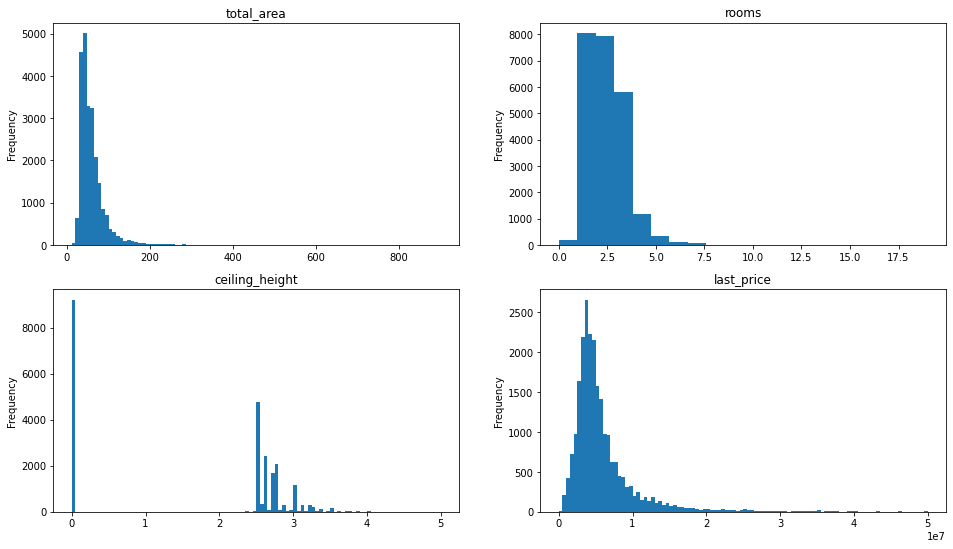

In [22]:
plt.figure(figsize=(16, 9))

ax1 = plt.subplot(2, 2, 1)

data['total_area'].plot(kind='hist', bins=100, title='total_area')

ax2 = plt.subplot(2, 2, 2,)
data['rooms'].plot(kind='hist', bins=20, title='rooms')

ax3 = plt.subplot(2, 2, 3, )
data['ceiling_height'].plot(kind='hist', bins=100, title='ceiling_height', range=(0, 5))

ax4 = plt.subplot(2, 2, 4, )
data['last_price'].plot(kind='hist', bins=100, title='last_price', range=(0,50000000))


plt.show()

In [23]:
for col in ['total_area', 'rooms', 'ceiling_height', 'last_price' ]:
    print(col, '\n', data[col].describe(), end='\n'*2)

total_area 
 count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

rooms 
 count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

ceiling_height 
 count    23699.000000
mean         1.696182
std          1.672495
min          0.000000
25%          0.000000
50%          2.500000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

last_price 
 count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64




На основании значений DataFrame построены гистограммы столбцов 'total_area' (общая площадь), 'rooms' (число комнат), 'ceiling_height'(высота потолков), 'last_price' (цена).  

Распределения значений показателей стремятся к нормальным, кроме столбца 'ceiling_height'. Он имеет множественные пики.


### Поиск и удаление выбросов

In [24]:
data.query('ceiling_height < 2 or ceiling_height > 5')['total_images'].count() / len(data['total_images'])

0.38963669353137265

In [25]:
data.query('rooms == 0 and studio == 0')['total_images'].count() / len(data['total_images'])

0.0024895565213722097

In [26]:
data.query('total_area > 200')['total_images'].count() / len(data['total_images'])

0.009578463226296468

In [27]:
data_correct = data.query('ceiling_height == 0 or ceiling_height >= 2 and ceiling_height <= 5')
data_correct = data_correct.query('rooms != 0 or studio')
data_correct = data_correct.query('total_area < 200')


Из первоначальной выборки данных можно убрать выбивающиеся значения по столбцам:
    
- 'ceiling_height' - значения менее двух и более 5 метров, однако чтобы не исказить анализ других показателей по всей выборке строки, содержавшие пропущенные значения не удалены.
- 'rooms' нулевые значения при условии параметра 'studio' равным False
- 'total_area' - значения более 200 м2

Эти данные сильно искажают средние значения по своим столбцам, однако их чсло менее 1% от всей выборки.    


## Анализ времени продажи квартиры

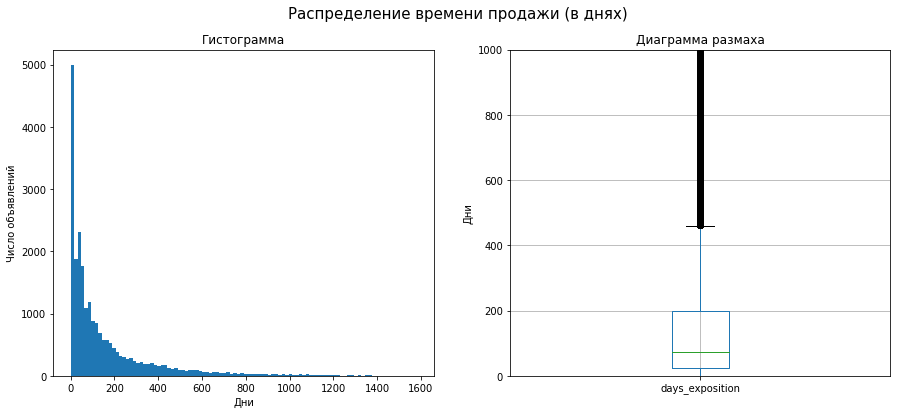

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

fig.suptitle('Распределение времени продажи (в днях)',
            fontsize=15)

axes[0] = plt.subplot(121).set_title('Гистограмма')
data_correct['days_exposition'].plot(kind='hist', 
                                     bins=100, 
                                    )
plt.ylabel('Число объявлений')
plt.xlabel('Дни')

axes[1] = plt.subplot(122).set_title('Диаграмма размаха')
plt.ylim(-0, 1000)
data_correct.boxplot(column=['days_exposition'])
plt.ylabel('Дни')

plt.show()

In [29]:
mean_days_exposition = data_correct['days_exposition'].mean()
median_days_exposition = data_correct['days_exposition'].median()
print(f"среднее арифметическое время продажи квартиры:{mean_days_exposition} дней \nмедианное время продажи квартиры: {median_days_exposition} дня")

среднее арифметическое время продажи квартиры:155.97454545454545 дней 
медианное время продажи квартиры: 74.0 дня


In [30]:
data_correct['days_exposition'].describe()

count    23375.000000
mean       155.974545
std        212.461090
min          0.000000
25%         23.000000
50%         74.000000
75%        198.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [31]:
data_correct[data_correct['days_exposition'] > 600]['total_images'].count() / len(data_correct['days_exposition'])

0.049967914438502674

In [32]:
data_correct[data_correct['days_exposition'] == 0]['total_images'].count() / len(data_correct['days_exposition'])

0.1335614973262032

In [33]:
data_correct = data_correct.query('days_exposition < 600')
data_correct['days_exposition'].describe()

count    22203.000000
mean       119.264964
std        135.482268
min          0.000000
25%         20.000000
50%         65.000000
75%        169.000000
max        599.000000
Name: days_exposition, dtype: float64


Среднее время продажи квартиры составляет 119 дней, в то время как медианное значение в два раза меньше 65 дня.
    
Это свидетельствует о наличии в выборке "длинных" выбросов (слишком долгих продаж).
    
Можно убрать из наблюдения слишком долгие продажи - срок размещения объявления которых свыше 600 дней.  
Доля таких объектов 5% от общего числа квартир.  
Однако в данных присутствуют квартиры с нулевой длительностью продаж и их 13% от общего числа.  
Такие данные искажают анализ и требуют уточнения.    


## Определение зависимости цены квартиры от площади, числа комнат, высота потолков

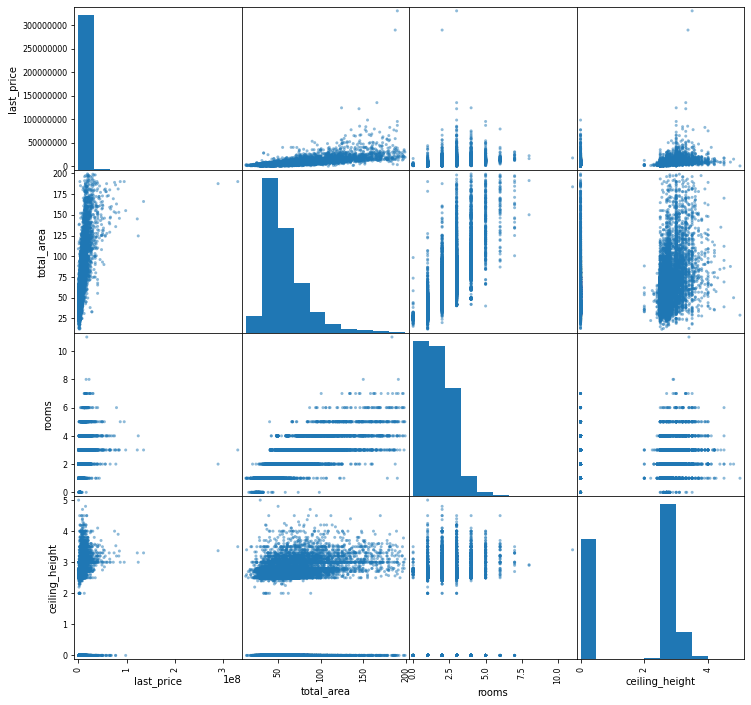

In [34]:
data_stat =data_correct[['last_price', 'total_area', 'rooms', 'ceiling_height']]

pd.plotting.scatter_matrix(data_stat, figsize=(12, 12)) 
plt.show()

In [35]:
data_stat.corr()

,last_price,total_area,rooms,ceiling_height
last_price,1.000000,0.655848,0.376186,0.110337
total_area,0.655848,1.000000,0.785110,0.117395
rooms,0.376186,0.785110,1.000000,0.100043
ceiling_height,0.110337,0.117395,0.100043,1.000000


Корреляция цены с:   
    
- "общая площадь" - зависимость прямая достаточно сильная, коэффиент Пирсона положительный. С ростом площади растет цена.
- "количество комнат" - зависимость прямая, коэффиент Пирсона положительный. С ростом количества комнат растет цена.
- "высота потолков" - зависимость очень слабая, коэффиент Пирсона близок к нулю.


In [36]:
data_stat_floor = data_correct.pivot_table(
    index='floor_number', 
    values='last_price', 
    aggfunc=['count','median']) 

data_stat_floor.columns = data_stat_floor.columns.droplevel(1)

data_stat_floor['median'] = data_stat_floor['median'].apply('{:,d}'.format)

data_stat_floor.sort_values('count', ascending=False)

,count,median
floor_number,,
другой,16399,"4,800,000"
последний,3069,"4,217,233"
первый,2735,"3,900,000"



Наибольшее число квартир в продаже на этажах кроме первого и последнего - 16399 шт.  
    
При этом медианная цена квартир на первом этаже самая низкая по сравнению с последним и всеми прочими.
    
Таким образом можно сделать вывод о наличии взаимосвязи между этажом и ценой квартиры.    


In [37]:
days = ["понедельник", "вторник", "среда", "четверг", "пятница", "суббота", "воскресенье"]
days = pd.DataFrame(days, columns=['week_day_name'])

data_stat_week = data_correct.pivot_table(
    index='week_day', 
    values='last_price', 
    aggfunc=['count', 'median']).reset_index()

data_stat_week.columns = data_stat_week.columns.droplevel(1)

data_stat_week = data_stat_week.merge(days, left_on='week_day', right_on=days.index )

data_stat_week = data_stat_week.set_index('week_day')

data_stat_week = data_stat_week[['week_day_name','count', 'median']]

data_stat_week.sort_values(by='count')

,week_day_name,count,median
week_day,,,
6,воскресенье,1595,4500000
5,суббота,1823,4500000
0,понедельник,3395,4600000
2,среда,3694,4600000
4,пятница,3782,4550000
1,вторник,3923,4690000
3,четверг,3991,4600000


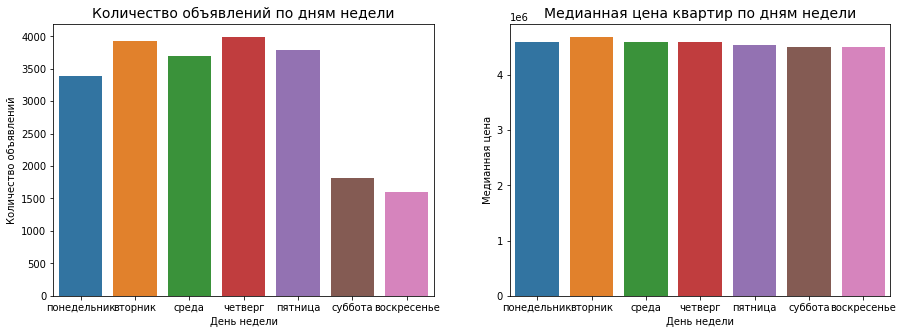

In [38]:
fig, axes = plt.subplots(1,2, figsize=(15,5))

axes[0] = plt.subplot(121)
sns.barplot(
    data = data_stat_week,
    x='week_day_name',
    y='count',
    

)
plt.xlabel('День недели')
plt.ylabel('Количество объявлений')
plt.title('Количество объявлений по дням недели',
         fontsize=14)

axes[0] = plt.subplot(122)
sns.barplot(
    data = data_stat_week,
    x='week_day_name',
    y='median',
    
    

)
plt.xlabel('День недели')
plt.ylabel('Медианная цена')
plt.title('Медианная цена квартир по дням недели',
         fontsize=14)

plt.show()


Количество объявлений в рабочие дни публикуется больше, чем в выходные. Между разными рабочими днями разница по количеству объявлений несущественна.  
Медианная цена квартир во все дни, как рабочие так и выходные, практически одинакова.    
    
Таким образом можно сделать вывод об отсутствии взаимосвязи между днем недели в который было подано объявление и ценой квартиры.    


In [39]:
month = ["январь", "февраль", "март", "апрель", "май", "июнь", "июль", "август", "сентябрь", "октябрь", "ноябрь", "декабрь"]
data_stat_month = data_correct.pivot_table(
    index='month', 
    values='last_price',
    aggfunc=['count', 'median']
)

data_stat_month.columns = ['count', 'median']
data_stat_month["month_name"] = month
data_stat_month.sort_values(by='count', ascending=False)

,count,median,month_name
month,,,
2,2496,4600000,февраль
3,2387,4600000,март
4,2259,4750000,апрель
11,2240,4650000,ноябрь
10,2023,4530000,октябрь
9,1860,4610000,сентябрь
8,1667,4550000,август
6,1638,4350000,июнь
7,1590,4600000,июль


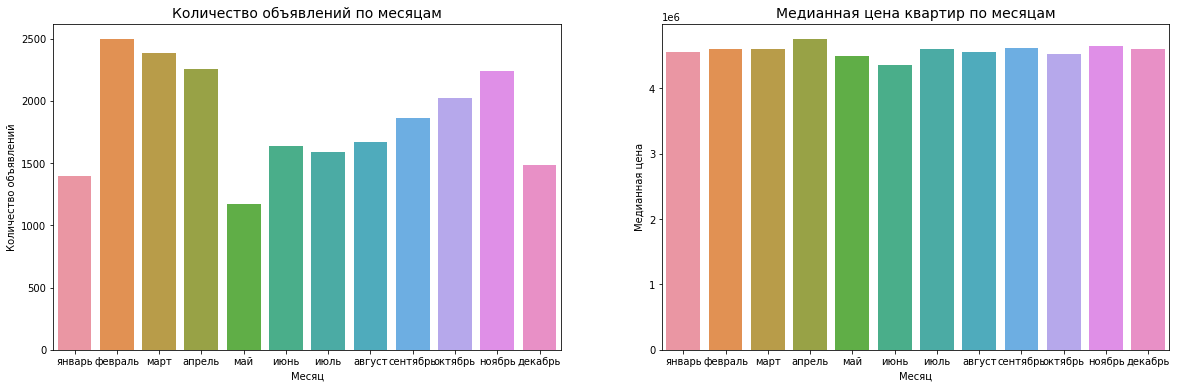

In [40]:
fig, axes = plt.subplots(1,2, figsize=(20,6))

axes[0] = plt.subplot(121)
sns.barplot(
    data = data_stat_month,
    x='month_name',
    y='count',
    

)
plt.xlabel('Месяц')
plt.ylabel('Количество объявлений')
plt.title('Количество объявлений по месяцам',
         fontsize=14)

axes[0] = plt.subplot(122)
sns.barplot(
    data = data_stat_month,
    x='month_name',
    y='median',
    
    

)
plt.xlabel('Месяц')
plt.ylabel('Медианная цена')
plt.title('Медианная цена квартир по месяцам',
         fontsize=14)

plt.show()


Количество объявлений в разные месяца года имеет широкий разброс: максимальное значение в феврале 2523 шт, минимальное в мае 1182 шт.  
    
Медианная цена квартир в зависимости от месяца подачи объявления изменяется слабо.     
    
Таким образом можно сделать вывод об отсутствии взаимосвязи между месяцем, в который было подано объявление, и ценой квартиры. 

In [41]:
data_stat_year = data_correct.pivot_table(index='year',
                                          values=['last_price', 'sq_meter_price'], 
                                          aggfunc=['count', 'median']
                                         )
data_stat_year.columns = ['count_flat_price', 'count_sq_meter_price', 'median_flat_price',  'median_sq_meter_price']
data_stat_year

,count_flat_price,count_sq_meter_price,median_flat_price,median_sq_meter_price
year,,,,
2014,46,46,9050000,113774.238965
2015,650,650,5083500,91715.686275
2016,2305,2305,4450000,91194.968553
2017,7909,7909,4500000,92222.222222
2018,8443,8443,4550000,95625.000000
2019,2850,2850,5000000,103328.870216


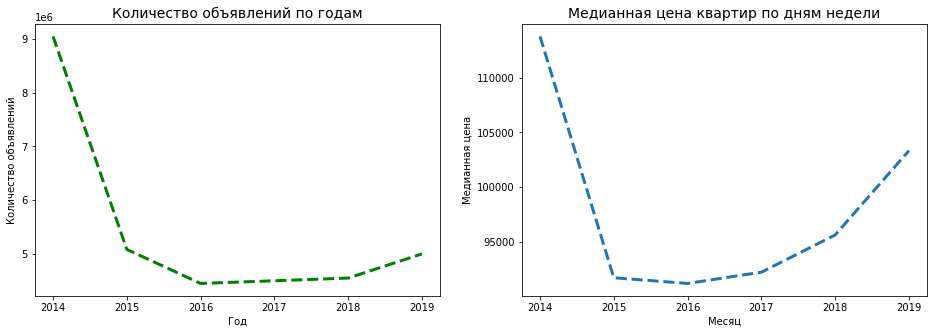

In [42]:
plt.figure(figsize=(16,5))

axes[0] = plt.subplot(121)
sns.lineplot(
    data = data_stat_year,
    x='year',
    y='median_flat_price',
    linestyle='--',
    linewidth=3,
    color='green',

)
plt.xlabel('Год')
plt.ylabel('Количество объявлений')
plt.title('Количество объявлений по годам',
         fontsize=14)

axes[0] = plt.subplot(122)
sns.lineplot(
    data = data_stat_year,
    x='year',
    y='median_sq_meter_price',
    linestyle='--',
    linewidth=3
)

plt.xlabel('Месяц')
plt.ylabel('Медианная цена')
plt.title('Медианная цена квартир по дням недели',
         fontsize=14)

plt.show()

В DataFrame представлены данные за 6 лет. 
    
В 2014 максимальная медианная цена, с 2015 началось ее снижение, относительная стабилизация 2016-2018 гг, и снова рост в 2019.
Тренд по ценам за квадратный метр достаточно близок к тренду по медианной цене, однако рост с 2018 года не такой существенный.
    
Зависимость цены от года публикации объявления налицо.    
    


## Топ-10 населенных пунктов по количеству объявлений

In [43]:
top_10_local_names = data_correct.pivot_table(
    index='locality_name', 
    values='total_images', 
    aggfunc='count').sort_values('total_images', ascending=False).head(10)

top_10_locals = data_correct.query('locality_name in @top_10_local_names.index')

local_avg_price = top_10_locals.pivot_table(
    index='locality_name', 
    values='sq_meter_price').sort_values('sq_meter_price')

print(f"Населенный пункт с максимальной средней ценой: {local_avg_price.index[-1]}. \
Она составляет: {int(local_avg_price.values[-1])} руб/м2")
print(f"Населенный пункт с минимальной средней ценой: {local_avg_price.index[0]}. \
Она составляет: {int(local_avg_price.values[0])} руб/м2")

Населенный пункт с максимальной средней ценой: Санкт-Петербург. Она составляет: 113238 руб/м2
Населенный пункт с минимальной средней ценой: Выборг. Она составляет: 58191 руб/м2



В зависимости от количества поданных объявлений выделено 10 населенных пунктов с их максимальным числом.   
    
Наибольшая средняя цена за квадратный метр среди этих населенных пунктов в г. Санкт-Петербург, наименьшая в г. Выборг.    


## Зависимость цены от близости к центру Санкт-Петербурга

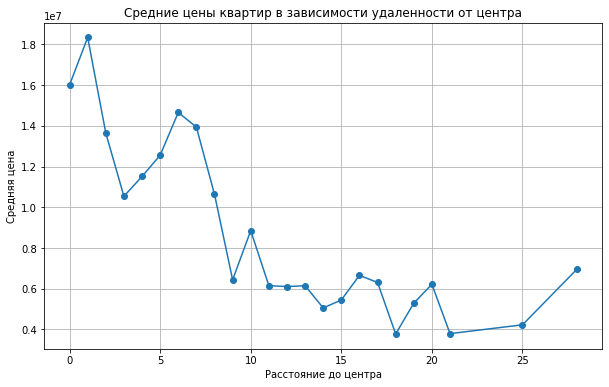

In [44]:
data_spb = data_correct.query('locality_name == "Санкт-Петербург"').dropna()

data_spb['cityCenters_km'] = (data_spb['cityCenters_nearest']/1000).astype('int64')

avg_price_km = data_spb.pivot_table(
    index='cityCenters_km', 
    values='last_price')

avg_price_km.plot(
    figsize=(10, 6),
    style='o-', 
    grid=True,
    legend=False
) 

plt.title('Средние цены квартир в зависимости удаленности от центра')
plt.xlabel('Расстояние до центра')
plt.ylabel('Средняя цена')
plt.show()


Произведен расчет цены в зависмости от удаленности квартиры от центра.
    
"Цена киллометра" значительно снижается на отметке 8 км. - центральную зону можно ограничить этим значением


## Сегмент квартир в центральной зоне г. Санкт-Петербурга

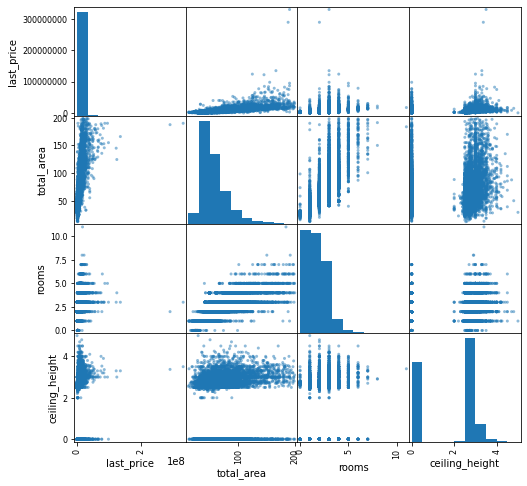

In [45]:
pd.plotting.scatter_matrix(data_stat, figsize=(8, 8)) 
plt.show()

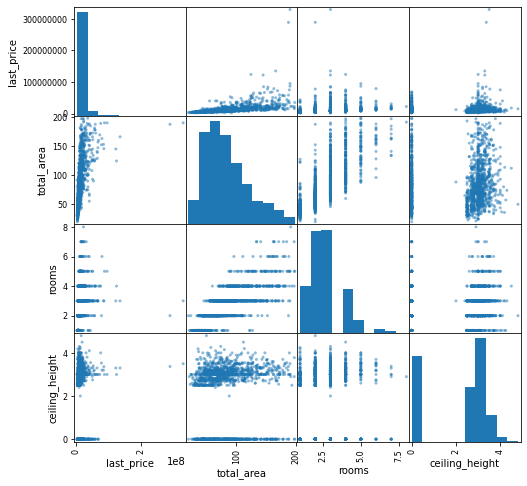

In [46]:
data_spb_center = data_spb.query('cityCenters_km <= 8')
data_stat_spb =data_spb_center[['last_price', 'total_area', 'rooms', 'ceiling_height']]
pd.plotting.scatter_matrix(data_stat_spb, figsize=(8, 8)) 
plt.show()

При попарном сравнении распределений показателей столбцов
'last_price', 'total_area', 'rooms', 'ceiling_height' в разрезе всей выборки и сегмента центра можно заметить следующее:
    
- гистограмма распределения по цене в таком разрезе значительных колебаний не имеет.
- значения цены и общей площади связаны достаточно тесно, при росте одного показателя растет и другой. При увеличении площади 
свыше 130 м2 завимость несколько ослабевает - наблюдается широкая зона с разбросом значений. Это характерно и для всей выборки,
и сегмента центра.
- взаимосвязь цены и количества комнат: наибольший разброс цен у 2-4 комнатных квартир в центре Санкт-Петербурга и 
    2-5 комнатных по всей выборке.
- связь цены и высоты потолков практически отсутствует, разброс значений на графике центра чуть менее широкий, чем по всей выборке    
- гистограмма распределения общей площади квартир в центре имеет более "широкий" вид, 
что свидетельствует о большем разбросе частот значений.
- связь общей площади квартиры и количества комнат присутствует, однако 
наблюдается достаточно широкая вариативность значений площади относительно количества комнат. 
Такая зависимость характерна и для всей выборки и сегмента центра.
- связи площади квартиры и высоты потолков не наблюдается - широкий разброс значений.
- гистограмма распределения количества комнат имеет серьезные различия для всего массива наблюдения и квартир в центе.
В общей выборке частота встречаемости 0-3 комнатных квартир наиболее частая, 4 несколько меньше, 
и начиная с 5 комнатных встречаемость самая низкая. В сегменте центра 0-1 комнатные квартиры представлены в 2 раза реже,
чем 2-3 комнатные. При этом имеется пропуск на значении 4 комнатных квартир.
- взаимосвязь количества комнат и высоты потолков: наибольший разброс высот у 0-3 комнатных квартир в центре Санкт-Петербурга и 
    1-5 комнатных по всей выборке.
- гистограмма распределения высоты потолков имеет 2 пика: в значении 0 и 3 метров, 
однако вариативность значений у центральном сегменте значительно шире - пик рамещен на 2,5-3,5 метрах.
В то время как в общей выборке пик более ярко выражен на 2,5 метрах


## Общий вывод


В ходе анализа DataFrame были проверены гипотезы о существовании зависимости цены квартиры от общей площади, числа комнат, высоты потолков и расположения относительно центра города.  

Была проведена работа с по анализу объявлений продажи квартир в разрезе показателей:
    цены, общей площади, количества комнат, высоты потолков, стоимости квадратного метра. 
    
Анализ проводился в двух направлениях: по всей предоставленной выборке данных и по сегменту центра Санкт-Петербурга.

Для выявления закономерностей влияния изучаемых факторов друг на друга главным образом использовалось построение матриц диаграмм рассеяния.    
    
Дополнительно анализировалось:
время (длительность) продажи квартир,
зависимость цены от дня недели, месяца и года подачи объявления, а также категории квартиры основанной на этаже размещения
    (первый, последний, любой другой).

**Получены результаты:**  
    
- *зависимость цены квартиры от общей площади* получила свое подтверждение, зависимость данных показателей наблюдается как по всей выборке, так и по отдельному сегменту.   
   
- *зависимость цены квартиры от числа комнат* получила свое подтверждение частично, зависимость данных показателей наблюдается, но коэффиицент Пуассона довольно (низкий около 0,3). Что говорит о несильной линейной связи этих показателей.
    
- *зависимость цены квартиры от высоты потолков*  не подтвердилась.  Однако при сравнении общих показателей и показателей сегмента центра наблюдается рост зависимости высоты потолков / цены квартиры.
